**Part 1 : Miscellaneous**

In [236]:
#Installations

#!pip install emoji
#!pip install nltk
#!pip install transformers
#!pip install torch
#!pip install sentence_transformers
#!pip install textblob
#!pip install keras
#!pip install tensorflow

In [237]:
#Environment details
import platform
import sys

# Python version
python_version = platform.python_version()

# Operating system
os_name = platform.system()
os_version = platform.version()

# Computer details
machine = platform.machine()

# Display information
print(f"Python Version: {python_version}")
print(f"Operating System: {os_name} {os_version}")
print(f"Machine: {machine}")


Python Version: 3.11.5
Operating System: Windows 10.0.22631
Machine: AMD64


In [298]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import emoji
import random
import string
from nltk.corpus import stopwords
import nltk
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from textblob import TextBlob
import itertools
from collections import defaultdict
from transformers import AutoTokenizer, AutoModel
from transformers import BertweetTokenizer, RobertaModel
import torch
from transformers import RobertaConfig
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

**Part 2 : Loading Dataset**

In [239]:
#Loading the dataset
path = os.getcwd()
dataset_path = path + '/dataset'
dfs = []
for i,fname in enumerate(os.listdir(dataset_path)):
    if fname.endswith('.xlsx'):
        file_path = os.path.join(dataset_path, fname)
        df = pd.read_excel(file_path)
        dfs.append(df)
df = pd.concat(dfs,ignore_index=True)
df.head()

,question,reply,replies_count,up_counts,relevance_score,relevance_rating
0,What are some terms in 90s that are no longer ...,Our friend's kid made fun of my wife for using...,12,358,NaN,NaN
1,What are some terms in 90s that are no longer ...,"Terms like ""talk to the hand,"" ""all that and a...",23,754,NaN,NaN
2,What are some terms in 90s that are no longer ...,"""The Information Superhighway"" is a term I've ...",11,514,NaN,NaN
3,What are some terms in 90s that are no longer ...,"Back where I grew up, being called a ""poser"" w...",27,1067,NaN,NaN
4,What are some terms in 90s that are no longer ...,Da bomb,9,357,NaN,NaN


In [240]:
df.shape

(12113, 6)

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12113 entries, 0 to 12112
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          12113 non-null  object 
 1   reply             12112 non-null  object 
 2   replies_count     12113 non-null  int64  
 3   up_counts         12113 non-null  int64  
 4   relevance_score   0 non-null      float64
 5   relevance_rating  3908 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 567.9+ KB


**Part 3 : Basic Preprocessing**

In [242]:
df.rename(columns={'reply': 'comment'}, inplace=True)
df.rename(columns={'up_counts': 'score'}, inplace=True)

In [243]:
#Dropping the records with no reply.
df = df.dropna(subset=['comment'])

In [244]:
#Drop duplicate records.
df.drop_duplicates(subset=['question', 'comment'], keep='first', inplace=True)

In [245]:
#Dropping the records which are deleted/removed posts.
invalid_posts = ['[deleted]','[removed]']
df = df[~df['comment'].isin(invalid_posts)]

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11564 entries, 0 to 12112
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          11564 non-null  object 
 1   comment           11564 non-null  object 
 2   replies_count     11564 non-null  int64  
 3   score             11564 non-null  int64  
 4   relevance_score   0 non-null      float64
 5   relevance_rating  3763 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 632.4+ KB


In [247]:
#Cleaning the comment data.
def clean_text(text):
    #Removing the attached urls
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '', text)
    #Replacing the \n with spaces
    text = text.replace('\n', ' ')
    #Removing the extra spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    #Removing the emojis
    text = emoji.demojize(text)
    return text
df['comment'] = df['comment'].apply(clean_text)

In [248]:
print(df.sample(n=5))

                                                question  \
11741  Which cities in America is baseball more popul...   
1258   What do y’all think is the Best iphone 15 pro ...   
3538   What’s a food you went your whole life thinkin...   
7921   What is a Pokemon you love that isn't very pop...   
9995             What is your favourite game of all time   

                                                 comment  replies_count  \
11741                          Think you missed the joke              1   
1258   If you are going to use a case. Color doesn’t ...              0   
3538   It took me entirely too long to actually try z...              0   
7921                                              Krabby              0   
9995   It will be quite unexpected for many people, b...              0   

       score  relevance_score  relevance_rating  
11741      6              NaN               1.0  
1258       1              NaN               8.0  
3538       1              NaN         

In [249]:
#Checking the target.
df['relevance_rating'].value_counts()

relevance_rating
6.0     766
1.0     607
8.0     518
7.0     510
9.0     381
10.0    331
3.0     164
2.0     149
5.0     147
4.0     116
0.0      74
Name: count, dtype: int64

There are null values and 0 as well when the considered scale is from 1-10.

In [250]:
#replacing the 0s with 1s
df['relevance_rating'] = df['relevance_rating'].replace(0.0, 1.0)
df['relevance_rating'].value_counts()

relevance_rating
6.0     766
1.0     681
8.0     518
7.0     510
9.0     381
10.0    331
3.0     164
2.0     149
5.0     147
4.0     116
Name: count, dtype: int64

Imbalanced data based on the relevance_ratings.

**Part 4 : Visualizations**

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11564 entries, 0 to 12112
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          11564 non-null  object 
 1   comment           11564 non-null  object 
 2   replies_count     11564 non-null  int64  
 3   score             11564 non-null  int64  
 4   relevance_score   0 non-null      float64
 5   relevance_rating  3763 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 632.4+ KB


In [252]:
#Shuffling the records.
df = df.sample(frac=1).reset_index(drop=True)

In [253]:
df.describe()

,replies_count,score,relevance_score,relevance_rating
count,11564.000000,11564.000000,0.0,3763.000000
mean,0.467572,9.940678,NaN,5.771725
std,1.984870,69.525364,NaN,2.944052
min,0.000000,-62.000000,NaN,1.000000
25%,0.000000,1.000000,NaN,3.000000
50%,0.000000,1.000000,NaN,6.000000
75%,0.000000,3.000000,NaN,8.000000
max,90.000000,3470.000000,NaN,10.000000


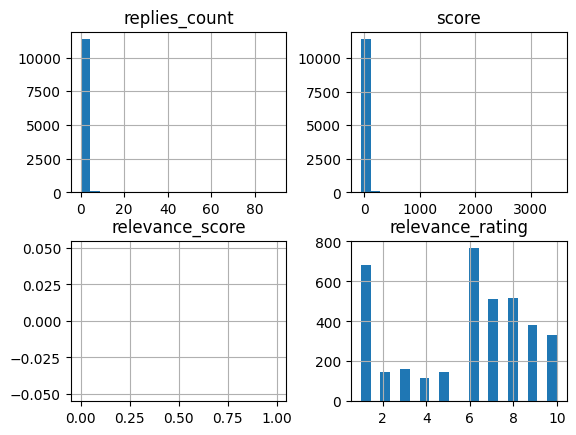

In [254]:
#Continuous values 
df.hist(bins = 20)
plt.show()

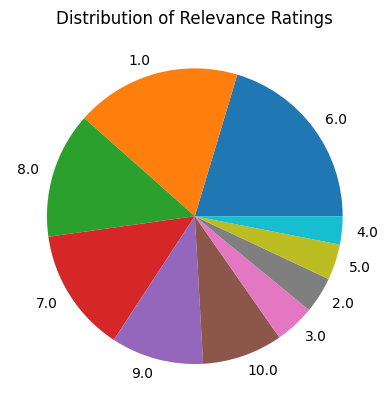

In [255]:
df['relevance_rating'].value_counts().plot.pie()
plt.title('Distribution of Relevance Ratings')
plt.ylabel('')
plt.show()

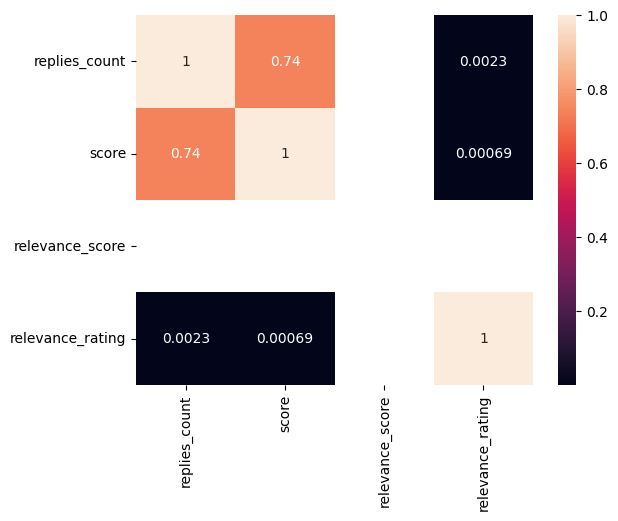

In [256]:
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()

In [257]:
#Just for visualization:
df['question'].value_counts()

question
What’s a food you went your whole life thinking it was nasty until you tried it?    3368
What is a Pokemon you love that isn't very popular or talked about?                 2491
What is your favourite game of all time                                             1251
What are some terms in 90s that are no longer used today?                           1015
What's the worst thing about living alone?                                           930
What do y’all think is the Best iphone 15 pro max color?                             898
Which cities in America is baseball more popular than football?                      888
Anyone else feel like LinkedIn is overrated to job searching?                        330
What are your favorite gadgets that make life just a little bit easier?              259
Is Youtube music better than Spotify?                                                134
Name: count, dtype: int64

In [258]:
label_encoder = LabelEncoder()
df_question_encoded = df.copy()
df_question_encoded['question'] = label_encoder.fit_transform(df_question_encoded['question'])

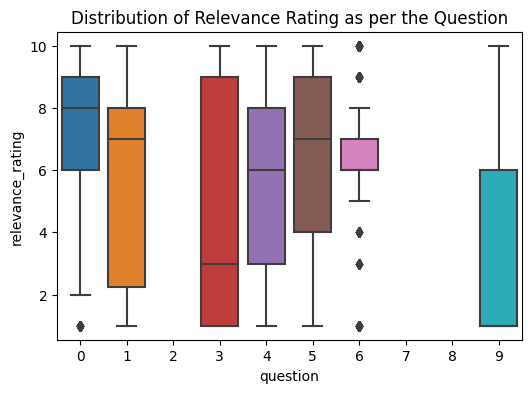

In [259]:
#Distribution of relevance_rating as per the questions.
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_question_encoded, x='question', y='relevance_rating')
plt.title('Distribution of Relevance Rating as per the Question')
plt.show()

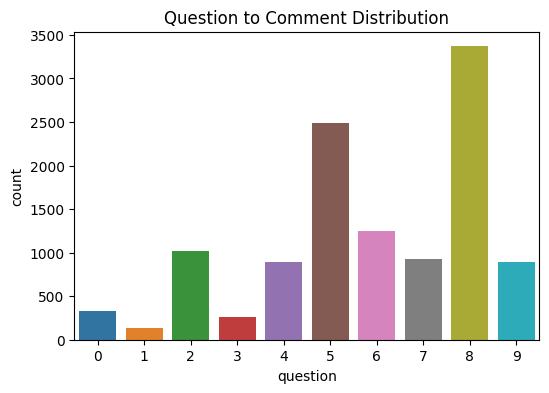

In [260]:
#Distribution of comments as per questions.
plt.figure(figsize=(6, 4))
sns.countplot(data=df_question_encoded, x='question')
plt.title('Question to Comment Distribution')
plt.show()

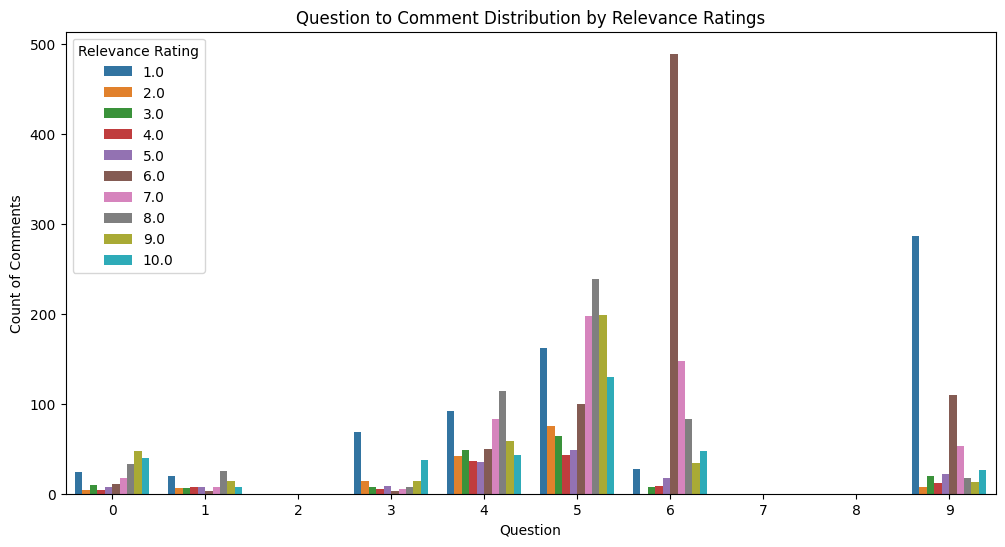

In [261]:
#Question to Comment Distribution divided by Relevance Ratings
plt.figure(figsize=(12, 6))
sns.countplot(data=df_question_encoded, x='question', hue='relevance_rating')
plt.title('Question to Comment Distribution by Relevance Ratings')
plt.xlabel('Question')
plt.ylabel('Count of Comments')
plt.legend(title='Relevance Rating')
plt.show()

**Part 5 : Constructing our metric to calculate relevance as better as possible**

This is all good and fine but in the end how do we find which answers are with good relevance and which are not? <br>
To acheive this, we need to consider various factors like :
1. The semantic similarity of the comment to the question
2. The syntax match of comment to the question
3. The polarity of the comment
4. If we consider clusters, then the coherence factor
5. User engagement factors (like upvotes/downvotes)
6. Temporal relevance (timestamp factor)
7. diversity of perspectives
8. spam/irrelevant content detection in here as well

In [262]:
def calculate_sentiment_probabilities(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity
    
def calculate_cosine_similarity_tfidf(question_embedding,cluster_comment_embeddings):
    return cosine_similarity(question_embedding,cluster_comment_embeddings)
    
def calculate_cluster_coherence_tfidf(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    cluster_comment_embeddings_arr = np.array([comment[0] for comment in cluster_comment_embeddings])
    print(cluster_comment_embeddings_arr)
    print(cluster_comment_embeddings_arr.shape)
    if len(cluster_comment_embeddings_arr.shape) > 2:
        cluster_comment_embeddings_arr = cluster_comment_embeddings_arr.reshape(cluster_comment_embeddings_arr.shape[0], -1)
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings_arr)
    coherence = np.mean(pairwise_similarity)
    similarity = calculate_cosine_similarity_tfidf(question_embedding,cluster_comment_embeddings_arr)
    return (coherence,similarity)
    
def calculate_cluster_coherence_lda(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    cluster_comment_embeddings_arr = np.array(cluster_comment_embeddings)
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings_arr)
    coherence = np.mean(pairwise_similarity)
    similarity = calculate_cosine_similarity_tfidf(question_embedding,cluster_comment_embeddings_arr)
    return (coherence,similarity)
    
def calculate_cosine_similarity_pre_trained(question_embedding,cluster_comment_embeddings):
    return cosine_similarity([question_embedding],cluster_comment_embeddings)[0]

def calculate_cluster_coherence_pre_trained(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings)
    coherence = np.mean(list(itertools.chain.from_iterable(pairwise_similarity)))
    similarity = calculate_cosine_similarity_pre_trained(question_embedding,cluster_comment_embeddings)
    return (coherence,similarity)

def calculate_relevance_scores(df, question_embedding,cluster_embeddings, topics, mode):
    relevance_scores = []
    
    for key,cluster_comments in topics.items():
        # Extracting the comments in this cluster
        df_temp = df[df['comment'].isin(cluster_comments)]
        
        # User engagement factors: score and reply counts
        max_score = max(df_temp['score'])
        min_score = min(df_temp['score'])
        normalized_scores = [(s - min_score) / (max_score - min_score) for s in df_temp['score']]
        
        max_replies = max(df_temp['replies_count'])
        min_replies = min(df_temp['replies_count'])
        normalized_replies = [(count - min_replies) / (max_replies - min_replies) for count in df_temp['replies_count']]
        
        # Cluster coherence,semantic similarity
        coherence,semantic_similarity = eval('calculate_cluster_coherence_' + mode)(question_embedding,cluster_embeddings,key)
        
        # Sentiment polarity of each comment
        sentiments = [calculate_sentiment_probabilities(comment) for comment in cluster_comments]
        max_sentiment = max(sentiments)
        min_sentiment = min(sentiments)
        normalized_sentiment = [(sentiment - min_sentiment) / (max_sentiment - min_sentiment) for sentiment in sentiments]

        # Calculate relevance score for the current cluster
        relevance_score = np.mean(normalized_scores) + (0.25*np.mean(normalized_replies)) + np.mean(normalized_sentiment) + np.mean(semantic_similarity) + coherence        
        relevance_scores.append((str(key),relevance_score))
        
    relevances = [r for _, r in relevance_scores]
    max_relevance = max(relevances)
    min_relevance = min(relevances)
    normalized_relevances = [(relevance - min_relevance) / (max_relevance - min_relevance) for relevance in relevances]
    
    # Create a dictionary with comments as keys and normalized sentiments as values
    relevance_scores = dict(zip(topics.keys(), normalized_relevances))
    return relevance_scores

**Part 6 : Getting into models**

Tried going the supervised way but giving accurate labelling to the posts on our own was kind of stiffling and we tried semi supervised way to give lables to the rest of the data by using label propogation - not very good results. <br>
Check the file : Initial working - Label propogation.ipynb in the same folder. <br>
Hence we are dabbling with unsupervised way now : 

Well ultimately what we need to do is to assign proper weights/embeddings to the words in the sentence so that the similarity metrics later used will provide good outputs. <br>
So the process flow is :
- consider an algorithm/model to assign weights to the sentences i.e, the approach is to create a complex model where the input is a string, and the output is a representation of the word or sentence (called embedding) and these embeddings should accurately represent the syntax and semantic.
- then use a similarity/distance metric among the embeddings to give a number!
- We can also use correlation coefficients i guess (lets check)

Some context for this : there are multiple ways to provide an embedding:<br>
1. Using simple similarity metrics like - cosine similiarity, Word Mover's Distance, Levenshtein distance, Hamming distance etc.
2. Using Word Embeddings (Spacy,bag-of-words,tf-idf,smooth inverse frequency)
3. Word2Vec or Doc2Vec
4. Pre-trained encoders (Transfer learning)
5. Bert embeddings
6. OpenAI
7. Siamese Networks? - needs labelling itseems
8. Semantic matching techniques ?
9. Transformers using attention mechanism

But the above points are all good for finding the syntax and similarity. How about contextual relevance then? <br>
Possible options for us to try would be : 
- Pre-trained models like bert and gpt
- Siamese networks
- Semantic matching models

I am going to use all of these and also in combinations (hybrid models).

 - <strong>Tf-Idf with Nearest neighbors</strong>

In [263]:
nltk.download('stopwords')
stop = stopwords.words('english')

def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    clean_text = re.sub(pattern, '', text)    
    return clean_text
    
#Not using this for now!
def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop])

df['comment'] = df['comment'].apply(remove_special_characters).str.lower()
df['question'] = df['question'].apply(remove_special_characters).str.lower()
df.head()

[nltk_data] Downloading package stopwords to C:\Users\Vineetha
[nltk_data]     Maddikunta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,question,comment,replies_count,score,relevance_score,relevance_rating
0,whats a food you went your whole life thinking...,canned tuna,0,1,NaN,NaN
1,what is a pokemon you love that isnt very popu...,linoone for definite kinda shit but i love it,0,1,NaN,NaN
2,what is a pokemon you love that isnt very popu...,lopunny seriously that pokemon is adorable and...,0,1,NaN,NaN
3,what is your favourite game of all time,considering your other two choices i am now go...,2,8,NaN,NaN
4,what is a pokemon you love that isnt very popu...,chingling is a nicely designed mon,0,1,NaN,7.0


Lets check the basic similarities between the question and replies and among replies as well.

In [264]:
question1df = df[df['question'] == df['question'][0]]

question = question1df['question'][0]
comments = question1df['comment'].to_numpy(dtype='object')

In [265]:
vectorizer = TfidfVectorizer()
comment_vectors = vectorizer.fit_transform(question1df['comment'])
question_vectors = vectorizer.transform(question1df['question'])

# Compute pairwise cosine similarity between sentence vectors
cosine_similarities = cosine_similarity(comment_vectors)
cosine_similarities_qv = cosine_similarity(comment_vectors, question_vectors)

# Print cosine similarity matrix
print("Cosine Similarity Matrix:")
print(pd.DataFrame(cosine_similarities))

Cosine Similarity Matrix:
      0         1         2     3         4         5         6         7     \
0      1.0  0.000000  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
1      0.0  1.000000  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
2      0.0  0.000000  1.000000   0.0  0.025549  0.000000  0.000000  0.007982   
3      0.0  0.000000  0.000000   1.0  0.000000  0.000000  0.035979  0.000000   
4      0.0  0.000000  0.025549   0.0  1.000000  0.077075  0.000000  0.055609   
...    ...       ...       ...   ...       ...       ...       ...       ...   
3363   0.0  0.033855  0.025632   0.0  0.000000  0.000000  0.052228  0.000000   
3364   0.0  0.000000  0.009000   0.0  0.034004  0.000000  0.000000  0.032293   
3365   0.0  0.000000  0.074438   0.0  0.058780  0.000000  0.019247  0.027555   
3366   0.0  0.024691  0.000000   0.0  0.032054  0.000000  0.051813  0.014102   
3367   0.0  0.070114  0.035397   0.0  0.033290  0.000000  0.011318  0.075195   

          8  

In [266]:
def get_top_similar_pairs(cosine_similarity_matrix):
    num_records = cosine_similarity_matrix.shape[0]
    pairs = []

    # Iterate through upper triangle of similarity matrix
    for i in range(num_records):
        for j in range(i+1, num_records):
            pairs.append(((i, j), cosine_similarity_matrix[i, j]))

    # Sort pairs by similarity score in descending order
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs

top_n = 5
top_similar_pairs = get_top_similar_pairs(cosine_similarities)
top_pairs = top_similar_pairs[:top_n]
print("Top", top_n, "similar pairs:")
for pair, similarity_score in top_pairs:
    print("Pair:", pair, "Similarity Score:", similarity_score)
    print(question1df.iloc[pair[0]]['comment'], "\nand\n" , question1df.iloc[pair[1]]['comment'])
    print("--------------------------------------")

Top 5 similar pairs:
Pair: (180, 1245) Similarity Score: 1.0000000000000002
wait what 
and
 wait what
--------------------------------------
Pair: (264, 1937) Similarity Score: 1.0000000000000002
black pudding 
and
 black pudding
--------------------------------------
Pair: (622, 2940) Similarity Score: 1.0000000000000002
onion rings 
and
 onion rings
--------------------------------------
Pair: (799, 800) Similarity Score: 1.0000000000000002
brussel sprouts 
and
 brussel sprouts
--------------------------------------
Pair: (799, 1691) Similarity Score: 1.0000000000000002
brussel sprouts 
and
 brussel sprouts
--------------------------------------


In [267]:
top_similar_pairs = get_top_similar_pairs(cosine_similarities_qv)
top_pairs = top_similar_pairs[:top_n]
print("Top", top_n, "similar pairs:")
for pair, similarity_score in top_pairs:
    print("Pair:", pair, "Similarity Score:", similarity_score)
    print(question1df.iloc[pair[0]]['comment'], "\nand\n" , question1df.iloc[pair[1]]['comment'])
    print("--------------------------------------")

Top 5 similar pairs:
Pair: (1807, 1808) Similarity Score: 0.4994208100023223
so you went your whole life until age 12 
and
 so does that mean you hate corn
--------------------------------------
Pair: (1807, 1809) Similarity Score: 0.4994208100023223
so you went your whole life until age 12 
and
 sushi its the best thing ive ever eaten
--------------------------------------
Pair: (1807, 1810) Similarity Score: 0.4994208100023223
so you went your whole life until age 12 
and
 sour cream  i have food aversion to condiments and sauces and have been getting braver at trying them as an adult i went from a tiny taste on a taco to ordering 3 sides of it for my burritos at a restaurant and buying it to have at home for tacos and chili and potatoes my mom would be sooooo mad
--------------------------------------
Pair: (1807, 1811) Similarity Score: 0.4994208100023223
so you went your whole life until age 12 
and
 did you know that broccoli leaves are very similar to kale and very tasty too
---

In [268]:
nn_model = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
nn_model.fit(comment_vectors.toarray())

# Query the model to find the most similar sentence to the first sentence
query_vec = vectorizer.transform([' '.join(df['question'][0])])
distances, indices = nn_model.kneighbors(query_vec.toarray(), return_distance=True)

# Print the most similar sentence
print(indices)
print("Most similar sentence to '{}'".format(df['question'][0]))
for i in indices[0]:
    print(question1df.iloc[i]['comment'])
    print("\n")

[[2244 2242 2247 2246 2245 2249]]
Most similar sentence to 'whats a food you went your whole life thinking it was nasty until you tried it'
mushrooms i thought they were slimy and smelled bad turns out they are slimy and smelly but taste delicioso


my dad forced my younger brother to eat a bite of rhubarb pie after complaining about no dessert being available as he didnt want to eat the pie turns out little bro likes rhubarb pie and requested it instead of cake for his birthday


why are they so much better


pecan is my absolute favorite pie


pickles hated them turns out the only time i experienced then was a kid was in mcdonalds hamburgers had a delightful bread and butter a year or so ago i love pickles


rice uncle bens turned me off to rice joined the navy and was stationed in subic bay philippines and discovered how great rice can be beamingfacewithsmilingeyes




In [269]:
num_topics = 5  
kmeans_tfidf = KMeans(n_clusters=num_topics)
kmeans_tfidf.fit(comment_vectors)

# Assign each comment to a cluster
cluster_labels_tfidf = kmeans_tfidf.labels_

cluster_embeddings_tfidf = defaultdict(list)
for i, label in enumerate(cluster_labels_tfidf):
    cluster_embeddings_tfidf[label].append(comment_vectors[i])
cluster_embeddings_tfidf = dict(cluster_embeddings_tfidf)

# Print comments belonging to each cluster (topic)
topics_tfidf = {}
for i, comment in enumerate(comments):
    if cluster_labels_tfidf[i] not in topics_tfidf:
        topics_tfidf[cluster_labels_tfidf[i]] = []
    topics_tfidf[cluster_labels_tfidf[i]].append(comment)

In [270]:
filtered_data = {key: value[:4] for key, value in topics_tfidf.items()}
pd.DataFrame(filtered_data)

,3,0,2,1,4
0,canned tuna,fried green tomatoes they just sounded disgust...,hahaha the crunch is the sound your bank accou...,cottage cheese looks like tonsil stones in mil...,avocados i just tried it for the first time la...
1,hahah its so quick too like 5 minutes after ea...,black olives im 28 and just tried them last we...,yep french beans in butter and garlic are out ...,i didnt like cheese as a kid exceptions for pi...,brussels sprouts i thought it would taste like...
2,meat parfaits duck or chicken liver parfait ar...,when i was a child we ate them raw but with su...,broccoli used to tast horrible in the 80s is a...,kimchi grilled cheese is great too,kimchi it doesnt help it smells like garbage i...
3,no those taste different,what did they do to the roasties to make them ...,just give me a tuna straight out of the sea an...,i prefer ranch but blue cheese is nice to mix ...,my mum makes a great meatloaf my health consci...


In [271]:
# relevance_scores_tfidf = calculate_relevance_scores(question1df,question_vectors,cluster_embeddings_tfidf,topics_tfidf,'tfidf')
# print("Relevance Scores for Each Cluster:", relevance_scores_tfidf)

- **Latent Dirichlet Allocation (LDA) for topic modeling**

In [272]:
# Vectorize the corpus using TF-IDF
vectorizer2 = TfidfVectorizer()
X = vectorizer2.fit_transform([question] + comments)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
lda_model.fit(X)

# Transform question and comments to topic distributions
question_topic = lda_model.transform(vectorizer2.transform([question]))
comment_topics = lda_model.transform(vectorizer2.transform(comments))

# Calculate cosine similarity between question topic and comment topics
similarity_scores = cosine_similarity(question_topic, comment_topics)[0]

# Filter relevant comments based on semantic similarity
threshold = np.percentile(similarity_scores, 50)  # Adjust threshold as needed
relevant_comments = [(comment,score) for comment, score in zip(comments, similarity_scores)]
relevant_comments = sorted(relevant_comments, key=lambda x: x[1], reverse=True)
print("Question : ",question)
print("Relevant comments:")
for comment,score in relevant_comments:
    print("-", comment,score)

Question :  whats a food you went your whole life thinking it was nasty until you tried it
Relevant comments:
- i know this sounds weird but try it with sour cream its delectable 0.9999999999967547
- chicken salad it grossed me out until i was an adult and tried it 0.9999999993444011
- sour cream used to totally avoid it but fuck its delicious 0.9999999982150891
- i like how this has evolved into a meatloaf thread im here for it 0.9999999977511962
- i tried mole sauce on chicken and cheesy nachos yesterday and couldnt believe i denied myself this flavor for decades 0.9999999946977048
- lol my mom always made awesome meatloaf so i truly didnt understand all the tv and book references to meatloaf being gross 0.9999999933602393
- one of the great lies i was ever told is that my mother was a great cook 0.9999999904296608
- my mom makes date squares 2 or 3 times a year they dont last very long 0.9999999883135708
- tofu a lot of asian restaurants call it bean curd on the menu and for some re

Observations : 
1. Pretty accurate for correct ones but also classified a lot of correct ones as wrong ones.
2. Works good for small sentences but seems to be failing for longer sentences with more explanation.

In [273]:
num_topics = 5  
kmeans_lda = KMeans(n_clusters=num_topics)
kmeans_lda.fit(comment_topics)

# Assign each comment to a cluster
cluster_labels_lda = kmeans_lda.labels_

cluster_embeddings_lda = defaultdict(list)
for i, label in enumerate(cluster_labels_lda):
    cluster_embeddings_lda[label].append(comment_topics[i])
cluster_embeddings_lda = dict(cluster_embeddings_lda)

# Print comments belonging to each cluster (topic)
topics_lda = {}
for i, comment in enumerate(comments):
    if cluster_labels_lda[i] not in topics_lda:
        topics_lda[cluster_labels_lda[i]] = []
    topics_lda[cluster_labels_lda[i]].append(comment)

In [274]:
filtered_data = {key: value[:3] for key, value in topics_lda.items()}
pd.DataFrame(filtered_data)

,3,1,2,0,4
0,canned tuna,fried green tomatoes they just sounded disgust...,no shade on op but wait instead of weight crac...,cottage cheese looks like tonsil stones in mil...,goddamn danny tanner psyop he was secretly rep...
1,hahah its so quick too like 5 minutes after ea...,hahaha the crunch is the sound your bank accou...,you are right i completely retract my false st...,white rice,cock and balls
2,meat parfaits duck or chicken liver parfait ar...,yep french beans in butter and garlic are out ...,,cool,lengua cabesa squid octopus and oysters


In [275]:
relevance_scores_lda = calculate_relevance_scores(question1df,question_topic,cluster_embeddings_lda,topics_lda,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_lda)

Relevance Scores for Each Cluster: {3: 1.0, 1: 0.9339311775472016, 2: 0.5531017951937843, 0: 0.8505268045083876, 4: 0.0}


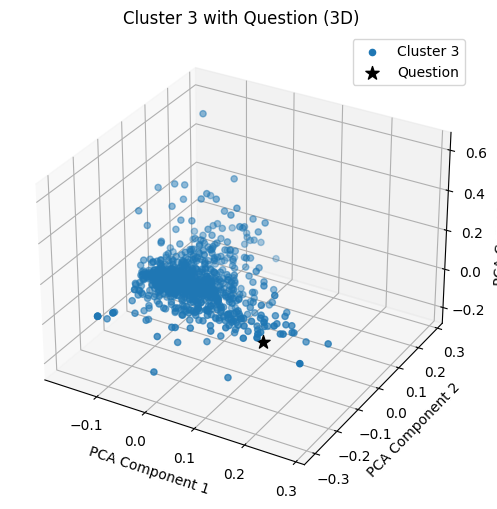

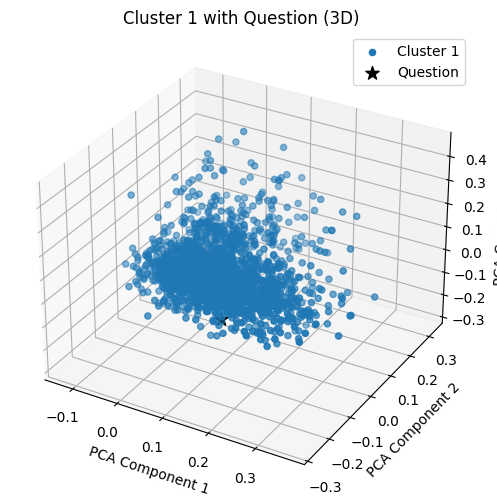

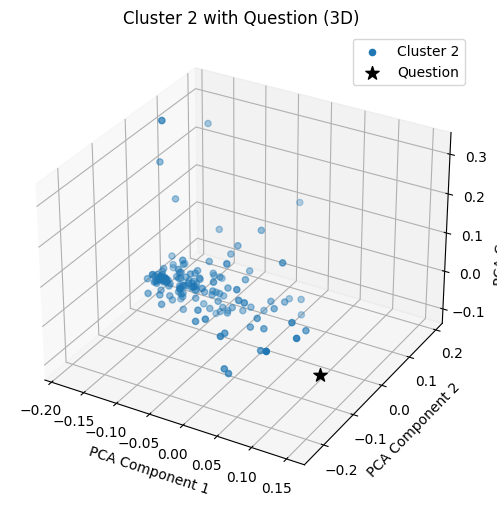

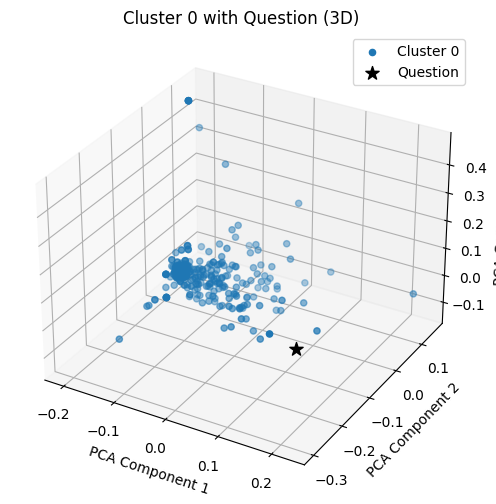

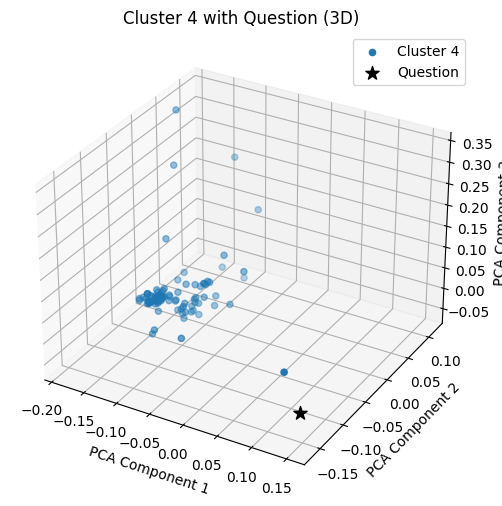

In [300]:
#Vectorize the comments using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([comment for comments in topics_lda.values() for comment in comments] + [question])

# Apply PCA to reduce dimensionality for visualization
pca = PCA(n_components=3)  # Modify PCA to reduce to 3 components
X_pca = pca.fit_transform(X.toarray())

# Plot each cluster along with the question in separate 3D plots
for cluster_label, cluster_comments in topics_lda.items():
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    start_idx = 0
    for i, (label, comments) in enumerate(topics_lda.items()):
        if label == cluster_label:
            cluster_indices = list(range(start_idx, start_idx + len(comments)))
            cluster_embeddings_pca = X_pca[cluster_indices]
            ax.scatter(cluster_embeddings_pca[:, 0], cluster_embeddings_pca[:, 1], cluster_embeddings_pca[:, 2], label=f'Cluster {label}')

        start_idx += len(comments)

    # Plot the question in 3D
    question_embedding_pca = X_pca[-1].reshape(1, -1)  # Last element corresponds to the question
    ax.scatter(question_embedding_pca[:, 0], question_embedding_pca[:, 1], question_embedding_pca[:, 2], color='black', marker='*', s=100, label='Question')

    ax.set_title(f'Cluster {cluster_label} with Question (3D)')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.legend()
    plt.show()

- **Pre-trained models** (Transfer Learning)

In [276]:
model = SentenceTransformer('paraphrase-distilroberta-base-v2')
comment_embeddings = model.encode(comments)
question_embedding = model.encode(question)
num_topics = 5  
kmeans = KMeans(n_clusters=num_topics)
kmeans.fit(comment_embeddings)

# Assign each comment to a cluster
cluster_labels = kmeans.labels_

cluster_embeddings = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings):
    cluster_label = cluster_labels[i]
    cluster_embeddings[cluster_label].append(comment_embedding)
cluster_embeddings = dict(cluster_embeddings)
# Print comments belonging to each cluster (topic)
topics = {}
for i, comment in enumerate(comments):
    if cluster_labels[i] not in topics:
        topics[cluster_labels[i]] = []
    topics[cluster_labels[i]].append(comment)

In [277]:
filtered_data = {key: value[:4] for key, value in topics.items()}
pd.DataFrame(filtered_data)

,4,2,1,0,3
0,canned tuna,hahah its so quick too like 5 minutes after ea...,meat parfaits duck or chicken liver parfait ar...,yep french beans in butter and garlic are out ...,no shade on op but wait instead of weight crac...
1,white rice,fried green tomatoes they just sounded disgust...,no those taste different,broccoli used to tast horrible in the 80s is a...,you are right i completely retract my false st...
2,just give me a tuna straight out of the sea an...,hahaha the crunch is the sound your bank accou...,black olives im 28 and just tried them last we...,brussels sprouts i thought it would taste like...,cool
3,quite a lot of indofijian places in new zealan...,i didnt like cheese as a kid exceptions for pi...,next time less olives more vodka throw some j...,goddamn danny tanner psyop he was secretly rep...,cock and balls


In [278]:
relevance_scores = calculate_relevance_scores(question1df,question_embedding,cluster_embeddings,topics,'pre_trained')
print("Relevance Scores for Each Cluster:", relevance_scores)

Relevance Scores for Each Cluster: {4: 0.8822856778936835, 2: 1.0, 1: 0.9463781088865589, 0: 0.9797265275303134, 3: 0.0}


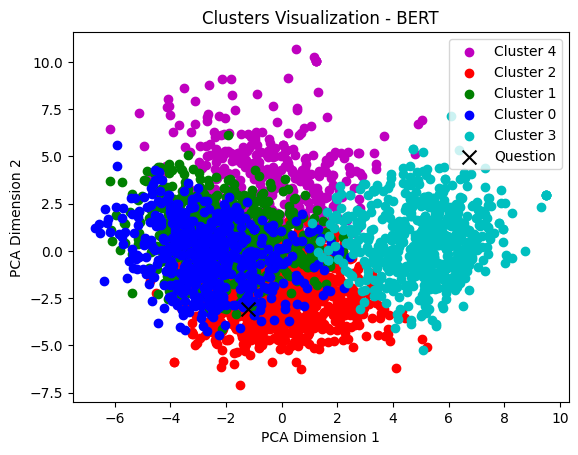

In [304]:
# Reduce dimensionality of embeddings using PCA
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(comment_embeddings)

# Define colors for clusters manually
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot each cluster
for cluster_label, comments in topics.items():
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_label]
    cluster_color = colors[cluster_label % len(colors)]
    cluster_comments_x = [reduced_embeddings[i][0] for i in cluster_indices]
    cluster_comments_y = [reduced_embeddings[i][1] for i in cluster_indices]
    plt.scatter(cluster_comments_x, cluster_comments_y, color=cluster_color, label=f'Cluster {cluster_label}')

# Plot the question
question_embedding_reduced = pca.transform(question_embedding.reshape(1, -1))
plt.scatter(question_embedding_reduced[:, 0], question_embedding_reduced[:, 1], color='black', label='Question', marker='x', s=100)

# Add legend and labels
plt.legend()
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Clusters Visualization - BERT')

# Show plot
plt.show()

- **Pre-trained models (Another version of Bert)**

In [279]:
comments.shape

(3368,)

In [280]:
model2 = SentenceTransformer('vinai/bertweet-base', device='cpu') 
comment_embeddings_m2 = []
for comment in comments:
    if len(comment) > model2.max_seq_length:
       comment = comment[:model2.max_seq_length]
    comment_embedding = model2.encode(comment)
    comment_embeddings_m2.append(torch.from_numpy(comment_embedding))
comment_embeddings_m2 = torch.stack(comment_embeddings_m2)
question_embedding_m2 = model2.encode(question)

num_topics = 5  
kmeans2 = KMeans(n_clusters=num_topics)
kmeans2.fit(comment_embeddings_m2)
cluster_labels_m2 = kmeans2.labels_

cluster_embeddings_m2 = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings_m2):
    cluster_label = cluster_labels_m2[i]
    cluster_embeddings_m2[cluster_label].append(comment_embedding)
cluster_embeddings_m2 = dict(cluster_embeddings_m2)

topics2 = {}
for i, comment in enumerate(comments):
    if cluster_labels_m2[i] not in topics2:
        topics2[cluster_labels_m2[i]] = []
    topics2[cluster_labels_m2[i]].append(comment)

No sentence-transformers model found with name vinai/bertweet-base. Creating a new one with MEAN pooling.


In [281]:
filtered_data = {key: value[:4] for key, value in topics2.items()}
pd.DataFrame(filtered_data)

,4,3,0,2,1
0,canned tuna,hahah its so quick too like 5 minutes after ea...,fried green tomatoes they just sounded disgust...,meat parfaits duck or chicken liver parfait ar...,hahaha the crunch is the sound your bank accou...
1,white rice,no shade on op but wait instead of weight crac...,yep french beans in butter and garlic are out ...,no those taste different,broccoli used to tast horrible in the 80s is a...
2,cool,goddamn danny tanner psyop he was secretly rep...,next time less olives more vodka throw some j...,strawberry rhubarb pie is also great,black olives im 28 and just tried them last we...
3,cock and balls,oh yeah my mistake lol still eat both though,cottage cheese looks like tonsil stones in mil...,pork rinds,avocados i just tried it for the first time la...


In [282]:
relevance_scores_m2 = calculate_relevance_scores(question1df,question_embedding_m2,cluster_embeddings_m2,topics2,'pre_trained')
print("Relevance Scores for Each Cluster:", relevance_scores_m2)

Relevance Scores for Each Cluster: {4: 0.058579670842129714, 3: 0.5692864664251754, 0: 0.8728404080861268, 2: 0.0, 1: 1.0}


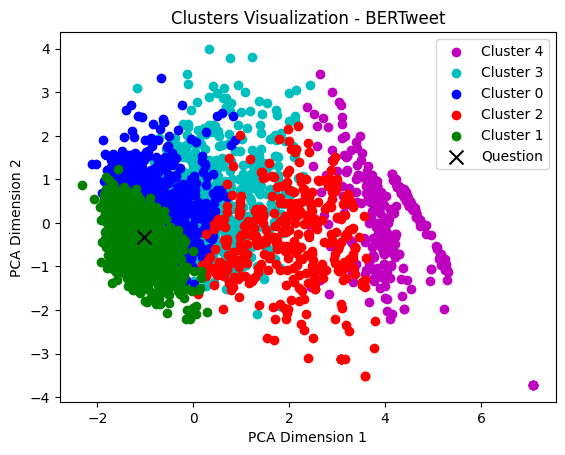

In [303]:
# Reduce dimensionality of embeddings using PCA
pca = PCA(n_components=2, random_state=42)
reduced_embeddings2 = pca.fit_transform(comment_embeddings_m2)

# Define default colors for clusters
default_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot each cluster with default colors
for cluster_label, comments in topics2.items():
    cluster_indices = [i for i, label in enumerate(cluster_labels_m2) if label == cluster_label]
    cluster_color = default_colors[cluster_label % len(default_colors)]  # Use default colors
    cluster_comments_x = [reduced_embeddings2[i][0] for i in cluster_indices]
    cluster_comments_y = [reduced_embeddings2[i][1] for i in cluster_indices]
    plt.scatter(cluster_comments_x, cluster_comments_y, color=cluster_color, label=f'Cluster {cluster_label}')

# Plot the question
question_embedding_reduced = pca.transform(question_embedding_m2.reshape(1, -1))
plt.scatter(question_embedding_reduced[0][0], question_embedding_reduced[0][1], color='black', label='Question', marker='x', s=100)

# Add legend and labels
plt.legend()
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Clusters Visualization - BERTweet')

# Show plot
plt.show()

- **LSTM model**

In [283]:
tokenizer_lstm = Tokenizer()
tokenizer_lstm.fit_on_texts(comments)
sequences = tokenizer_lstm.texts_to_sequences(comments)
vocab_size = len(tokenizer_lstm.word_index) + 1 
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Model hyperparameters
embedding_dim = 50 
# Define the model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_lstm.add(LSTM(units=64))

# Compile the model (not necessary if you're not training)
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Get embeddings
comment_embeddings_lstm = model_lstm.predict(padded_sequences)

106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step


In [284]:
tokenizer_lstm.fit_on_texts([question])
sequence = tokenizer_lstm.texts_to_sequences([question])
vocab_size = len(tokenizer_lstm.word_index) + 1
max_sequence_length = len(sequence[0])
padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
question_embeddings_lstm = model_lstm.predict(padded_sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


In [285]:
num_topics = 5  
kmeans_lstm = KMeans(n_clusters=num_topics)
kmeans_lstm.fit(comment_embeddings_lstm)

# Assign each comment to a cluster
cluster_labels_lstm = kmeans_lstm.labels_

cluster_embeddings_lstm = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings_lstm):
    cluster_label = cluster_labels_lstm[i]
    cluster_embeddings_lstm[cluster_label].append(comment_embedding)
cluster_embeddings_lstm = dict(cluster_embeddings_lstm)

# Print comments belonging to each cluster (topic)
topics_lstm = {}
for i, comment in enumerate(comments):
    if cluster_labels_lstm[i] not in topics_lstm:
        topics_lstm[cluster_labels_lstm[i]] = []
    topics_lstm[cluster_labels_lstm[i]].append(comment)

In [286]:
filtered_data = {key: value[:4] for key, value in topics2.items()}
pd.DataFrame(filtered_data)

,4,3,0,2,1
0,canned tuna,hahah its so quick too like 5 minutes after ea...,fried green tomatoes they just sounded disgust...,meat parfaits duck or chicken liver parfait ar...,hahaha the crunch is the sound your bank accou...
1,white rice,no shade on op but wait instead of weight crac...,yep french beans in butter and garlic are out ...,no those taste different,broccoli used to tast horrible in the 80s is a...
2,cool,goddamn danny tanner psyop he was secretly rep...,next time less olives more vodka throw some j...,strawberry rhubarb pie is also great,black olives im 28 and just tried them last we...
3,cock and balls,oh yeah my mistake lol still eat both though,cottage cheese looks like tonsil stones in mil...,pork rinds,avocados i just tried it for the first time la...


In [287]:
relevance_scores_lstm = calculate_relevance_scores(question1df,question_embeddings_lstm,cluster_embeddings_lstm,topics_lstm,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_lstm)

Relevance Scores for Each Cluster: {4: 0.9876345157863876, 3: 1.0, 1: 0.19766555225033022, 2: 0.3912083381437632, 0: 0.0}


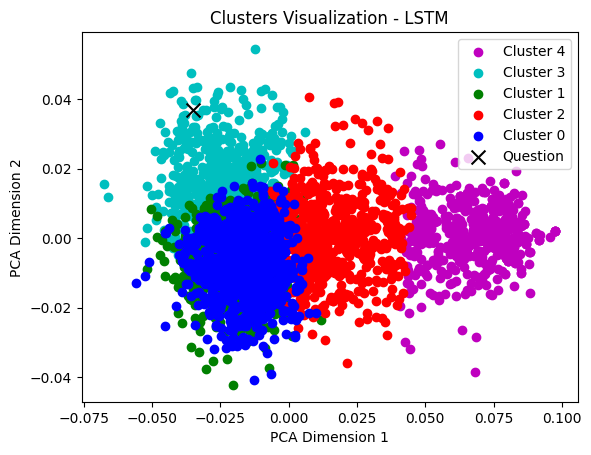

In [306]:
# Reduce dimensionality of embeddings using PCA
pca_lstm = PCA(n_components=2, random_state=42)
reduced_embeddings_lstm = pca_lstm.fit_transform(comment_embeddings_lstm)

# Plot each cluster
for cluster_label, comments in topics_lstm.items():
    cluster_color = colors[cluster_label % len(colors)]
    cluster_comments_x = [reduced_embeddings_lstm[i][0] for i in range(len(cluster_labels_lstm)) if cluster_labels_lstm[i] == cluster_label]
    cluster_comments_y = [reduced_embeddings_lstm[i][1] for i in range(len(cluster_labels_lstm)) if cluster_labels_lstm[i] == cluster_label]
    plt.scatter(cluster_comments_x, cluster_comments_y, color=cluster_color, label=f'Cluster {cluster_label}')

# Plot the question
question_embedding_reduced_lstm = pca_lstm.transform(question_embeddings_lstm)
plt.scatter(question_embedding_reduced_lstm[:, 0], question_embedding_reduced_lstm[:, 1], color='black', label='Question',marker = 'x',s = 100)

# Add legend and labels
plt.legend()
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Clusters Visualization - LSTM')

# Show plot
plt.show()

- **Hybrid model - LDA + Bert**

In [288]:
question_embedding.shape

(768,)

In [289]:
combined_embeddings1 = np.concatenate((comment_topics, comment_embeddings), axis=1)
question_embedding_reshaped = question_embedding.reshape(1, -1)
question_combined1 = np.concatenate((question_topic, question_embedding_reshaped), axis=1)
num_topics = 5
kmeans_hybrid1 = KMeans(n_clusters=num_topics)
kmeans_hybrid1.fit(combined_embeddings1)

# Assign each comment to a cluster
cluster_labels_hybrid1 = kmeans_hybrid1.labels_

cluster_embeddings_h1 = defaultdict(list)
for i, comment_embedding in enumerate(combined_embeddings1):
    cluster_label = cluster_labels_hybrid1[i]
    cluster_embeddings_h1[cluster_label].append(comment_embedding)
cluster_embeddings_h1 = dict(cluster_embeddings_h1)

# Print comments belonging to each cluster (topic)
topics_hybrid1 = {}
for i, comment in enumerate(comments):
    if cluster_labels_hybrid1[i] not in topics_hybrid1:
        topics_hybrid1[cluster_labels_hybrid1[i]] = []
    topics_hybrid1[cluster_labels_hybrid1[i]].append(comment)

In [290]:
filtered_data = {key: value[:4] for key, value in topics_hybrid1.items()}
pd.DataFrame(filtered_data)

,3,4,0,1,2
0,canned tuna,hahah its so quick too like 5 minutes after ea...,meat parfaits duck or chicken liver parfait ar...,yep french beans in butter and garlic are out ...,no shade on op but wait instead of weight crac...
1,white rice,fried green tomatoes they just sounded disgust...,no those taste different,broccoli used to tast horrible in the 80s is a...,you are right i completely retract my false st...
2,just give me a tuna straight out of the sea an...,hahaha the crunch is the sound your bank accou...,black olives im 28 and just tried them last we...,brussels sprouts i thought it would taste like...,cool
3,quite a lot of indofijian places in new zealan...,i didnt like cheese as a kid exceptions for pi...,next time less olives more vodka throw some j...,goddamn danny tanner psyop he was secretly rep...,cock and balls


In [291]:
relevance_scores_h1 = calculate_relevance_scores(question1df,question_combined1,cluster_embeddings_h1,topics_hybrid1,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_h1)

Relevance Scores for Each Cluster: {3: 0.8573753466294868, 4: 1.0, 0: 0.9379010937523048, 1: 0.9719331316061688, 2: 0.0}


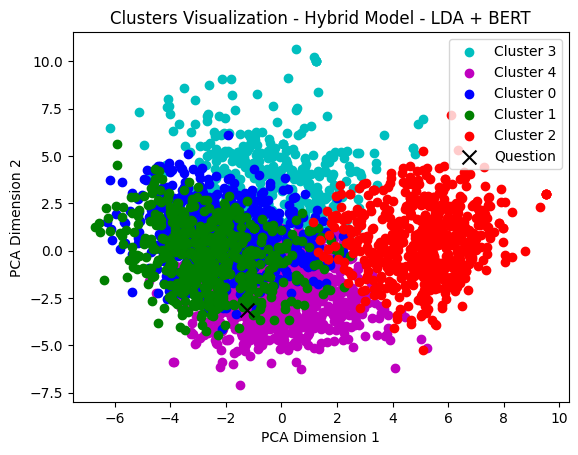

In [312]:
# Combine embeddings for comments and topics
combined_embeddings1 = np.concatenate((comment_topics, comment_embeddings), axis=1)
question_embedding_reshaped = question_embedding.reshape(1, -1)
question_combined1 = np.concatenate((question_topic, question_embedding_reshaped), axis=1)

# Perform dimensionality reduction using PCA
pca_hybrid = PCA(n_components=2, random_state=42)
reduced_embeddings_hybrid = pca_hybrid.fit_transform(combined_embeddings1)

# Define default colors for clusters
default_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot each cluster with default colors
for cluster_label, comments in topics_hybrid1.items():
    cluster_indices = [i for i, label in enumerate(cluster_labels_hybrid1) if label == cluster_label]
    cluster_color = default_colors[cluster_label % len(default_colors)]  # Use default colors
    cluster_comments_x = [reduced_embeddings_hybrid[i][0] for i in cluster_indices]
    cluster_comments_y = [reduced_embeddings_hybrid[i][1] for i in cluster_indices]
    plt.scatter(cluster_comments_x, cluster_comments_y, color=cluster_color, label=f'Cluster {cluster_label}')

# Plot the question
question_embedding_reduced = pca_hybrid.transform(question_combined1)
plt.scatter(question_embedding_reduced[0][0], question_embedding_reduced[0][1], color='black', label='Question', marker='x', s=100)

# Add legend and labels
plt.legend()
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Clusters Visualization - Hybrid Model - LDA + BERT')

# Show plot
plt.show()

- **Hybrid model - LDA + LSTM**

In [292]:
combined_embeddings2 = np.concatenate((comment_topics, comment_embeddings_lstm), axis=1)
question_embedding_reshaped = question_embeddings_lstm.reshape(1, -1)
question_combined2 = np.concatenate((question_topic, question_embedding_reshaped), axis=1)
num_topics = 5
kmeans_hybrid2 = KMeans(n_clusters=num_topics)
kmeans_hybrid2.fit(combined_embeddings2)

# Assign each comment to a cluster
cluster_labels_hybrid2 = kmeans_hybrid2.labels_

cluster_embeddings_h2 = defaultdict(list)
for i, comment_embedding in enumerate(combined_embeddings2):
    cluster_label = cluster_labels_hybrid2[i]
    cluster_embeddings_h2[cluster_label].append(comment_embedding)
cluster_embeddings_h2 = dict(cluster_embeddings_h2)

# Print comments belonging to each cluster (topic)
topics_hybrid2 = {}
for i, comment in enumerate(comments):
    if cluster_labels_hybrid2[i] not in topics_hybrid2:
        topics_hybrid2[cluster_labels_hybrid2[i]] = []
    topics_hybrid2[cluster_labels_hybrid2[i]].append(comment)

In [293]:
filtered_data = {key: value[:4] for key, value in topics_hybrid2.items()}
pd.DataFrame(filtered_data)

,4,0,3,1,2
0,canned tuna,hahah its so quick too like 5 minutes after ea...,fried green tomatoes they just sounded disgust...,no shade on op but wait instead of weight crac...,goddamn danny tanner psyop he was secretly rep...
1,cottage cheese looks like tonsil stones in mil...,meat parfaits duck or chicken liver parfait ar...,hahaha the crunch is the sound your bank accou...,you are right i completely retract my false st...,cock and balls
2,white rice,no those taste different,yep french beans in butter and garlic are out ...,,lengua cabesa squid octopus and oysters
3,cool,avocados i just tried it for the first time la...,broccoli used to tast horrible in the 80s is a...,,toot toot


In [294]:
relevance_scores_h2 = calculate_relevance_scores(question1df,question_combined2,cluster_embeddings_h2,topics_hybrid2,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_h2)

Relevance Scores for Each Cluster: {4: 0.8499587904106314, 0: 1.0, 3: 0.930698305113646, 1: 0.5451735558073858, 2: 0.0}


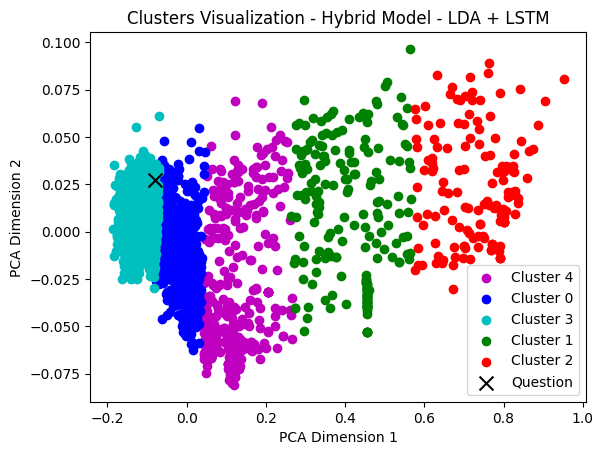

In [311]:
# Combine embeddings for comments and LSTM embeddings
combined_embeddings2 = np.concatenate((comment_topics, comment_embeddings_lstm), axis=1)
question_embedding_reshaped = question_embeddings_lstm.reshape(1, -1)
question_combined2 = np.concatenate((question_topic, question_embedding_reshaped), axis=1)

# Perform dimensionality reduction using PCA
pca_hybrid2 = PCA(n_components=2, random_state=42)
reduced_embeddings_hybrid2 = pca_hybrid2.fit_transform(combined_embeddings2)

# Define default colors for clusters
default_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot each cluster with default colors
for cluster_label, comments in topics_hybrid2.items():
    cluster_indices = [i for i, label in enumerate(cluster_labels_hybrid2) if label == cluster_label]
    cluster_color = default_colors[cluster_label % len(default_colors)]  # Use default colors
    cluster_comments_x = [reduced_embeddings_hybrid2[i][0] for i in cluster_indices]
    cluster_comments_y = [reduced_embeddings_hybrid2[i][1] for i in cluster_indices]
    plt.scatter(cluster_comments_x, cluster_comments_y, color=cluster_color, label=f'Cluster {cluster_label}')

# Plot the question
question_embedding_reduced = pca_hybrid2.transform(question_combined2)
plt.scatter(question_embedding_reduced[0][0], question_embedding_reduced[0][1], color='black', label='Question', marker='x', s=100)

# Add legend and labels
plt.legend()
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Clusters Visualization - Hybrid Model - LDA + LSTM')

# Show plot
plt.show()

- **Hybrid model - LDA + Bertweet**

In [295]:
combined_embeddings3 = np.concatenate((comment_topics, comment_embeddings_m2), axis=1)
question_embedding_reshaped = question_embedding_m2.reshape(1, -1)
question_combined3 = np.concatenate((question_topic, question_embedding_reshaped), axis=1)
num_topics = 5
kmeans_hybrid3 = KMeans(n_clusters=num_topics)
kmeans_hybrid3.fit(combined_embeddings3)

# Assign each comment to a cluster
cluster_labels_hybrid3 = kmeans_hybrid3.labels_

cluster_embeddings_h3 = defaultdict(list)
for i, comment_embedding in enumerate(combined_embeddings3):
    cluster_label = cluster_labels_hybrid3[i]
    cluster_embeddings_h3[cluster_label].append(comment_embedding)
cluster_embeddings_h3 = dict(cluster_embeddings_h3)

# Print comments belonging to each cluster (topic)
topics_hybrid3 = {}
for i, comment in enumerate(comments):
    if cluster_labels_hybrid3[i] not in topics_hybrid3:
        topics_hybrid3[cluster_labels_hybrid3[i]] = []
    topics_hybrid3[cluster_labels_hybrid3[i]].append(comment)

In [296]:
filtered_data = {key: value[:4] for key, value in topics_hybrid3.items()}
pd.DataFrame(filtered_data)

,1,3,2,0,4
0,canned tuna,hahah its so quick too like 5 minutes after ea...,fried green tomatoes they just sounded disgust...,hahaha the crunch is the sound your bank accou...,no those taste different
1,white rice,no shade on op but wait instead of weight crac...,meat parfaits duck or chicken liver parfait ar...,broccoli used to tast horrible in the 80s is a...,cock and balls
2,cool,goddamn danny tanner psyop he was secretly rep...,yep french beans in butter and garlic are out ...,black olives im 28 and just tried them last we...,strawberry rhubarb pie is also great
3,bagels cheesecake,oh yeah my mistake lol still eat both though,next time less olives more vodka throw some j...,avocados i just tried it for the first time la...,pork rinds


In [297]:
relevance_scores_h3 = calculate_relevance_scores(question1df,question_combined3,cluster_embeddings_h3,topics_hybrid3,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_h3)

Relevance Scores for Each Cluster: {1: 0.07662096739278167, 3: 0.5750288964598914, 2: 0.8108563199978064, 0: 1.0, 4: 0.0}


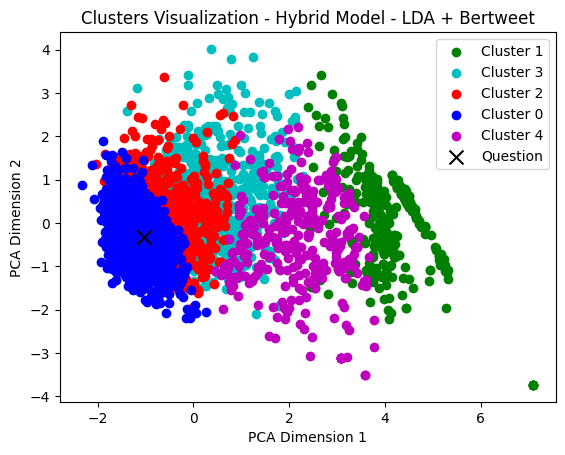

In [310]:
# Combine embeddings for comments and the third set
combined_embeddings3 = np.concatenate((comment_topics, comment_embeddings_m2), axis=1)
question_embedding_reshaped = question_embedding_m2.reshape(1, -1)
question_combined3 = np.concatenate((question_topic, question_embedding_reshaped), axis=1)

# Perform dimensionality reduction using PCA
pca_hybrid3 = PCA(n_components=2, random_state=42)
reduced_embeddings_hybrid3 = pca_hybrid3.fit_transform(combined_embeddings3)

# Define default colors for clusters
default_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot each cluster with default colors
for cluster_label, comments in topics_hybrid3.items():
    cluster_indices = [i for i, label in enumerate(cluster_labels_hybrid3) if label == cluster_label]
    cluster_color = default_colors[cluster_label % len(default_colors)]  # Use default colors
    cluster_comments_x = [reduced_embeddings_hybrid3[i][0] for i in cluster_indices]
    cluster_comments_y = [reduced_embeddings_hybrid3[i][1] for i in cluster_indices]
    plt.scatter(cluster_comments_x, cluster_comments_y, color=cluster_color, label=f'Cluster {cluster_label}')

# Plot the question
question_embedding_reduced = pca_hybrid3.transform(question_combined3)
plt.scatter(question_embedding_reduced[0][0], question_embedding_reduced[0][1], color='black', label='Question', marker='x', s=100)

# Add legend and labels
plt.legend()
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Clusters Visualization - Hybrid Model - LDA + Bertweet')

# Show plot
plt.show()